In [ ]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from data.loader import get_dataloader
from models.mnist_usps.models import SplitEncoder
from models.mnist_usps.models import SplitDecoder
from models.mnist_usps.models import LinearProbe
from utils.seed import set_seed
from utils.training import pretrain, pretrain_round_robin, pretrain_usage_swap_asym

In [3]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_loader = get_dataloader("mnist", batch_size=128, train=True)
test_loader  = get_dataloader("mnist", batch_size=128, train=False)

In [5]:
input_dim = 784
output_dim = 784
latent_dim = 64
signal_dim = 32
num_classes = 10

In [6]:
encoder = SplitEncoder(input_dim=input_dim, latent_dim=latent_dim, signal_dim=signal_dim).to(device)
decoder = SplitDecoder(latent_dim=latent_dim, output_dim=output_dim).to(device)
probe   = LinearProbe(input_dim=signal_dim, n_classes=num_classes).to(device)
label_probe = LinearProbe(input_dim=signal_dim, n_classes=num_classes).to(device)

In [8]:
import io, re
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

In [9]:
def run_with_logging(fn, *args, **kwargs):
    """Run training and parse printed losses into a dict."""
    buffer = io.StringIO()
    with redirect_stdout(buffer):
        fn(*args, **kwargs)   # call your existing training function
    output = buffer.getvalue()

    # --- parse printed output lines ---
    epoch_log = []
    pattern = re.compile(
        r"\[Pretrain\+Swap\(Asym\)\s*(\d+)/\d+\]\s*"
        r"Loss=([\d\.]+)\s*L_cls=([\d\.]+)\s*L_rec=([\d\.]+)"
    )
    for line in output.splitlines():
        m = pattern.search(line)
        if m:
            epoch, loss, cls, rec = map(float, m.groups())
            epoch_log.append({"epoch": epoch, "train_loss": loss, "cls": cls, "rec": rec})

    return epoch_log, output

In [11]:
logs, raw_output = run_with_logging(
    pretrain_usage_swap_asym,
    encoder, decoder, probe, train_loader, device,
    save_path="artifacts/replicate/mnist_pretrain_swap_asym.pt",
)

Epoch 20/20: 100%|██████████| 469/469 [00:09<00:00, 51.86it/s]


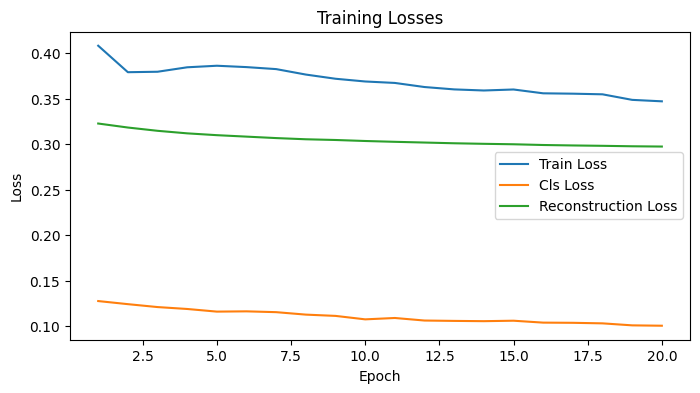

In [12]:
import pandas as pd
df = pd.DataFrame(logs)

plt.figure(figsize=(8,4))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["cls"], label="Cls Loss")
plt.plot(df["epoch"], df["rec"], label="Reconstruction Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Training Losses")
plt.show()